In [1]:
import matplotlib.pyplot as plt

import  seaborn as sns
sns.set_style("darkgrid")

from ExperientalTools import *

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

## get the dataset

In [2]:
(tr_x,tr_y) = prepare_dataset(train_path="datasets/ML-CUP21-TR.csv",unique=True)

In [3]:
# dictionary to save the results
results={}

## Constants

In [4]:
SIZE_RESERVOIR = 200
LAMBDA_REG = 1
MAX_ITER = 15000
PRECISION = 1e-2

## fix the resevoir

In [5]:
resevoir = np.random.uniform(-1, 1, (SIZE_RESERVOIR, 10))
H = sigmoid(resevoir @ tr_x)
E = H @ H.T + np.power(LAMBDA_REG, 2) * np.eye(H.shape[0])

In [6]:
condition_number = np.linalg.cond(E)
print(f"Condition number of E: {condition_number}")

Condition number of E: 73039.52322272636


# OPTIMAL SOLUTION

In [7]:
w_star,_,_,_ = np.linalg.lstsq(E, H@tr_y.T,rcond=-1)

In [8]:
results["Optimal"] = mse(w_star.T@H, tr_y), "-"

In [9]:
print("Mean square error: ", results["Optimal"][0])

Mean square error:  1.5829665193074671


## Cholesky solution

In [10]:
cholesky = fit_cholesky(tr_x, tr_y, lambda_=LAMBDA_REG, resevoir=resevoir)

In [11]:
cholesky_rel_gap_sol = np.linalg.norm(cholesky.w2 - w_star.T, ord="fro")/np.linalg.norm(w_star, ord="fro")
results["Cholesky"] = get_results(cholesky, tr_x, tr_y), cholesky_rel_gap_sol

In [12]:
print("Cholesky Mean square error: ", results["Cholesky"][0])
print("Cholesky Relative Gap Sol: ", results["Cholesky"][1])

Cholesky Mean square error:  1.582966519308065
Cholesky Relative Gap Sol:  1.7583222284414083e-11


## Iterative methods

In [13]:
classical_sgd = fit_sgd(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, max_inters=MAX_ITER,
                        eps=PRECISION, resevoir=resevoir, w_star=w_star.T, verbose=True)

In [14]:
sgd_gap_sol = classical_sgd["results"]["Rel_Gap_Sol"].tail(1).values[0]
results["classical-SGD"] = get_results(classical_sgd["model"], tr_x, tr_y), sgd_gap_sol

In [15]:
print("Mean square error: ", results["classical-SGD"][0])
print("Relative Gap Sol: ", results["classical-SGD"][1])

Mean square error:  1.77650779395441
Relative Gap Sol:  0.6769687504314427


In [16]:
fista = fit_fista(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, max_inters=MAX_ITER,
                  eps=PRECISION, resevoir=resevoir, w_star=w_star.T, verbose=True)

In [17]:
fista_gap_sol = fista["results"]["Rel_Gap_Sol"].tail(1).values[0]
results["Fista"] = get_results(fista["model"], tr_x, tr_y), fista_gap_sol

In [18]:
print("Mean square error: ", results["Fista"][0])
print("Relative Gap Sol: ", results["Fista"][1])

Mean square error:  1.5829250557218695
Relative Gap Sol:  0.0017080237711162287


In [19]:
fista["results"]

,MSE,Rel_Gap_Sol
iters,,
0,22.483377,1.182015
1,22.483377,1.182015
2,15.854278,1.180420
3,10.844528,1.179045
4,7.660590,1.177947
...,...,...
14995,1.582925,0.001712
14996,1.582925,0.001711
14997,1.582925,0.001710


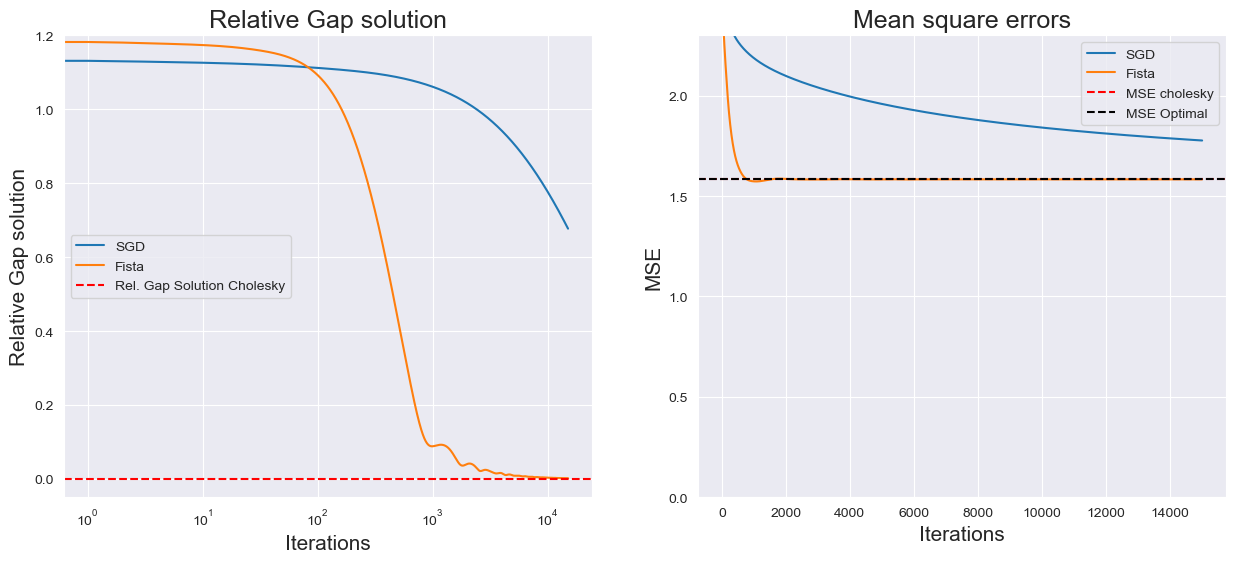

In [20]:
_, axs = plt.subplots(ncols=2,figsize=(15,6))

sns.lineplot(data=classical_sgd["results"], x=classical_sgd["results"].index, y="Rel_Gap_Sol", ax=axs[0], label="SGD")
sns.lineplot(data=fista["results"], x=fista["results"].index, y="Rel_Gap_Sol", ax=axs[0], label="Fista")
axs[0].axhline(y=cholesky_rel_gap_sol, label="Rel. Gap Solution Cholesky", color="red", linestyle="--")
axs[0].set_title("Relative Gap solution",fontsize=18)
axs[0].set_ylabel("Relative Gap solution",fontsize=15)
axs[0].set_xlabel("Iterations",fontsize=15)
axs[0].set_ylim([-0.05,1.2])
axs[0].set_xscale("log")
axs[0].legend()


sns.lineplot(data=classical_sgd["results"], x=classical_sgd["results"].index, y="MSE", ax=axs[1], label="SGD")
sns.lineplot(data=fista["results"], x=fista["results"].index, y="MSE", ax=axs[1], label="Fista")
axs[1].axhline(y=results["Cholesky"][0], label="MSE cholesky", color="red", linestyle="--")
axs[1].axhline(y=results["Optimal"][0], label="MSE Optimal", color="black", linestyle="--")
axs[1].set_title("Mean square errors",fontsize=18)
axs[1].set_ylabel("MSE",fontsize=15)
axs[1].set_xlabel("Iterations",fontsize=15)
axs[1].set_ylim([0, 2.3])
axs[1].legend()

plt.show()


In [21]:
print(f"{'Method' : ^20}{'MSE' : ^30}{'Rel. gap sol' : ^30}")

for k,v in results.items():
    print(f"{k : ^20}{v[0]:^30}{v[1] : ^30}")

       Method                    MSE                       Rel. gap sol         
      Optimal             1.5829665193074671                    -               
      Cholesky            1.582966519308065           1.7583222284414083e-11    
   classical-SGD           1.77650779395441             0.6769687504314427      
       Fista              1.5829250557218695          0.0017080237711162287     
